Tempo gasto: 4 horas

ambiente virtual: dados

In [1]:
import xarray as xr
import xesmf as xe

# Regridding usando o xESMF

[https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html](https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html)

[https://github.com/JiaweiZhuang/xESMF](https://github.com/JiaweiZhuang/xESMF)

[Documentação do ESMF](https://earthsystemmodeling.org/esmpy)

# Instalação

Instalação do ESMF:

* conda install -c conda-forge esmpy xarray scipy dask netCDF4
* pip install git+https://github.com/pangeo-data/xesmf.git

Para testar a instalação:
* pip install pytest
* pytest -v --pyargs xesmf  # Todos os testes devem ser aprovados.

# Exemplo de uso

Objetivo: Interpolar o arquivo de temperatura (25 km x 25 km) para o domínio espacial de precipitação (10 km x 10 km).

In [2]:
ds1 = xr.open_dataset("../dados/NetCDF/INPE_FireRiskModel_2.2_Precipitation_20210530.nc")  # Arquivo destino. Ou seja, interpolar o arquivo fonte para esta mesma resolução espacial.
ds2 = xr.open_dataset("../dados/NetCDF/INPE_FireRiskModel_2.2_Temperature_20210530.nc") # Arquivo fonte. Arquivo a ser interpolado.

In [3]:
ds1

<xarray.Dataset>
Dimensions:  (time: 1, lon: 850, lat: 901)
Coordinates:
  * time     (time) datetime64[ns] 2021-05-30
  * lon      (lon) float32 -114.9 -114.8 -114.7 -114.6 ... -30.25 -30.15 -30.05
  * lat      (lat) float32 -60.05 -59.95 -59.85 -59.75 ... 29.75 29.85 29.95
Data variables:
    prec     (time, lat, lon) float32 ...
Attributes: (12/15)
    history:                   Mon May 31 09:55:07 2021: ncpdq -O -a time,lat...
    NCO:                       "4.5.4"
    nco_openmp_thread_number:  1
    CDI:                       Climate Data Interface version 1.9.5 (http://m...
    Conventions:               CF-1.6
    BeginDate:                 2021-05-30
    ...                        ...
    FileHeader:                StartGranuleDateTime=2021-05-30T00:00:00.000Z;...
    InputPointer:              3B-HHR-E.MS.MRG.3IMERG.20210530-S000000-E00295...
    title:                     GPM IMERG Early Precipitation L3 1 day 0.1 deg...
    DOI:                       10.5067/GPM/IMERGDE/DAY/06
    ProductionTime:            2021-05-31T04:24:20.618Z
    CDO:                       Climate Data Operators version 1.9.5 (http://m...

In [4]:
ds2

<xarray.Dataset>
Dimensions:  (time: 1, lon: 345, lat: 361)
Coordinates:
  * time     (time) datetime64[ns] 2021-05-30T18:00:00
  * lon      (lon) float64 -116.0 -115.8 -115.5 -115.2 ... -30.5 -30.25 -30.0
  * lat      (lat) float64 -60.0 -59.75 -59.5 -59.25 ... 29.25 29.5 29.75 30.0
Data variables:
    temp2m   (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.5 (http://m...
    Conventions:               CF-1.6
    history:                   Mon May 31 09:50:04 2021: cdo -s -setmissval,-...
    institution:               National Centers for Environmental Prediction
    NCO:                       "4.5.4"
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.9.5 (http://m...

**Métodos de interpolação:**
* "bilinear"
* "conservative"
* "nearest_s2d"
* "nearest_d2s"
* "patch"

Para visualizar o melhor método, basta acessar o link abaixo:

[Comparação entre as diferentes possibilidades de interpolação](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Comparison-of-5-regridding-algorithms)

## Forma 1:

In [5]:
# Cria uma grade espacial que terá o mesmo número de pontos de lat/lon do arquivo destino.

coord_lat = ds1.lat.values  # Armazena os valores de latitude (coordenadas) do arquivo destino.
coord_lon = ds1.lon.values  # Armazena os valores de longitude (coordenadas) do arquivo destino.

# Cria a variável "ds_out". O "ds_out" será utilizado para interpolar o arquivo fonte.
ds_out = xr.Dataset({"lat": (["lat"], coord_lat), "lon": (["lon"], coord_lon)})

Como os pontos de coordenadas de `ds_out` estão iguais ao número de pontos de grade de destino (`ds1`). Agora, é possível realizar a interpolação.

In [6]:
# Reamostra as coordenadas do arquivo fonte (ds2) para a coordenadas que se deseja interpolar (ds_out).
regridder = xe.Regridder(ds2, ds_out, "bilinear")

In [7]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x345_901x850.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 345) 
Output grid shape:          (901, 850) 
Periodic in longitude?      False

In [8]:
# Aplica a interpolação (regridder) no arquivo fonte "ds2" (25 km x 25 km) que será convertido para o mesmo domínio 
# espacial de ds1 (10 km x 10 km).
ds2_int = regridder(ds2)

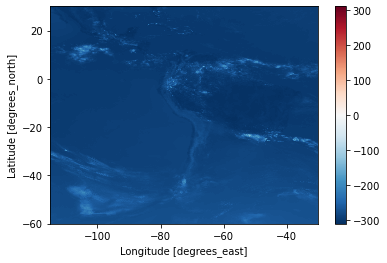

In [9]:
# Apenas uma checagem para saber se possuem os mesmos números de pontos de lat/lon. Para isso, foi 
# feita uma subtração entre os dois campos (não faz sentido, é apenas um teste). 
dif = ds1.prec[0,:,:] - ds2_int.temp2m[0,:,:]
dif.plot()

## Forma 2: Mais fácil

Basta passar o arquivo fonte como o primeiro argumento, e como segundo argumento, o arquivo de destino.

**Em resumo:** interpola as coordenadas de ds2 (25 km x 25 km) para a mesma resolução espacial de ds1 (10 km x 10 km) 
utilizando o método "bilinear".

In [10]:
regridder = xe.Regridder(ds2, ds1, "bilinear")

In [11]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x345_901x850.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 345) 
Output grid shape:          (901, 850) 
Periodic in longitude?      False

In [12]:
# Aplica a interpolação no arquivo fonte (ds2).
ds2_int= regridder(ds2)

In [13]:
# Mesmo caso acima, apenas para efeito de verificação para saber se estão na mesma resolução espacial.
dif = ds1.prec[0,:,:] - ds2_int.temp2m[0,:,:]

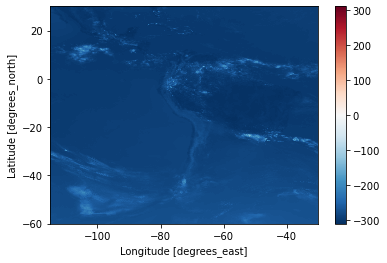

In [14]:
dif.plot()  # As figuras são iguais utilizando as duas forma de obter a interpolação.